# Cap 3 - 3.4. Linear Regression Implementation from Scratch

Implementação de regressão linear do zero

Nesta seção, implementaremos todo o método do zero, incluindo: 

(i) o modelo; # class LinearRegressionScratch:  def \_\__init\_\__; def foward

(ii) a função perda; #class LinearRegressionScratch:  def loss

(iii) um otimizador de descida de gradiente estocástico de minilote; e           # class SGD

(iv) a função de treinamento que une todas essas peças.

Embora as estruturas modernas de aprendizagem profunda possam automatizar quase todo esse trabalho, implementar coisas do zero é a única maneira de garantir que você realmente sabe o que está fazendo. Além disso, quando chegar a hora de personalizar modelos, definindo nossas próprias camadas ou funções de perda, será útil entender como as coisas funcionam nos bastidores. 




In [ ]:
!pip install d2l==1.0.3

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

# 3.4.1. Definindo o Modelo

Observe que para design orientado a objetos adicionamos o código ao __init__método de uma subclasse de d2l.Module

In [ ]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch (do zero)."""
    def __init__(self, num_inputs, lr, sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()                           # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
                                                     # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)   # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)                            #  bias=b=0.
        

A seguir devemos definir nosso modelo: 

y = Xw + b

Simplesmente tomamos o produto matriz_dados(X)*vetor_pesos(w) + b(escalar).

Quando adicionamos um vetor e um escalar, o escalar é adicionado a cada componente do vetor.

O método resultante forward é registrado na classe anterior LinearRegressionScratch via decorator @add_to_class: continuação da classe anterior.



In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  
def forward(self, X): #O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
    return torch.matmul(X, self.w) + self.b   # Produto entre X que é a matriz de dados e w que é o vetor de pesos

# 3.4.2. Definindo a Função de Perda

Como a atualização do nosso modelo requer a tomada do gradiente da nossa função de perda, devemos primeiro definir a função de perda. Aqui usamos a função de perda quadrada em (3.1.5) 

 valor verdadeiro: y
 
 valor previsto: y_hat. 

 

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat. 
    return l.mean()

# 3.4.3. Definindo o Algoritmo de Otimização

(iii) Otimizador de __Descida de Gradiente Estocástico (SGD)__ de minilote (minibatch).

Em cada etapa, usando um minilote sorteado aleatoriamente do nosso conjunto de dados, estimamos o gradiente da perda em relação aos parâmetros.

A seguir, atualizamos os parâmetros na direção que pode reduzir a perda.

Taxa de aprendizado: lr

Como nossa perda é calculada como uma média do minilote, não precisamos ajustar a taxa de aprendizado em relação ao tamanho do lote.

Definimos nossa classe SGD , uma subclasse de d2l.HyperParameters (introduzida na Seção 3.2.1 )

Atualizamos os parâmetros no método step.

O método zero_grad define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.

In [ ]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):                    # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad   # param = param - self.lr * param.grad

    def zero_grad(self):               # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

A seguir definimos o método configure_optimizers, que retorna uma instância da classe SGD.

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

# 3.4.4. Treinamento

Em cada época , iteramos por todo o conjunto de dados de treinamento, passando uma vez por cada exemplo (assumindo que o número de exemplos é divisível pelo tamanho do lote). 

Em cada iteração, pegamos um minilote de exemplos de treinamento e calculamos sua perda por meio do método training_step do modelo.

Em seguida, calculamos os gradientes em relação a cada parâmetro. 

Por fim, chamaremos o algoritmo de otimização para atualizar os parâmetros do modelo. 



Seguindo nosso design orientado a objetos, os métodos prepare_batch e fit_epoch são registrados na d2l.Trainerclasse (introduzido na Seção 3.2.4 )

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Estamos quase prontos para treinar o modelo, mas primeiro precisamos de alguns dados de treinamento. Aqui usamos a classe SyntheticRegressionData e passamos alguns parâmetros verdadeiros. 

Em seguida, treinamos nosso modelo com a taxa de aprendizado lr=0.03 e definimos max_epochs=3. Observe que, em geral, tanto o número de épocas quanto a taxa de aprendizado são hiperparâmetros. 



In [ ]:
model = LinearRegressionScratch(2, lr=0.03)  # 2 entradas   # __init__(self, num_inputs, lr, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2) # Demais parâmetros já estão atribuídos: 
                                                                     #__init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32)
trainer = d2l.Trainer(max_epochs=5)  # __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0)  # Demais parâmetros já estão atribuídos 
trainer.fit(model, data)

Como nós mesmos sintetizamos o conjunto de dados, sabemos exatamente quais são os verdadeiros parâmetros. Assim, podemos avaliar o nosso sucesso no treino comparando os parâmetros verdadeiros com aqueles que aprendemos através do nosso ciclo de treino.,


In [ ]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')




# Código Completo:


In [ ]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):  # Método Construtor: Recebe os atributos iniciais da classe ao criar um objeto
        super().__init__()               # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()      # Classe utilitária definida anteriormente
        self.board = ProgressBoard()     # Classe utilitária definida anteriormente

    def loss(self, y_hat, y):            # Função perda. Ainda não implementada.
        raise NotImplementedError

    def forward(self, X):                # Backpropagation?
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):   # plot
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):       # treinamento
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):     # validação
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):       # otimizadores
        raise NotImplementedError

# -------------------------------------------------------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self, X): #O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b   # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):                    # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad   # param = param - self.lr * param.grad

    def zero_grad(self):               # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):                   # Método chave. model é uma instância de Module, e data, uma instância de DataModule
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):  # @d2l.add_to_class(d2l.Trainer)  #@save
        return batch


    def fit_epoch(self):  # @d2l.add_to_class(d2l.Trainer)  #@save
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):  # usado para preparar os dados.
        self.save_hyperparameters()

    def get_dataloader(self, train):                    # Carregador de dados. Produz um lote de dados cada vez que é usado.
        raise NotImplementedError

    def train_dataloader(self):                         # retorna o carregador de dados para o conjunto de dados de treinamento.
        return self.get_dataloader(train=True)

    def val_dataloader(self):                           # opcional: retorna o carregador do conjunto de dados de validação.
        return self.get_dataloader(train=False)

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):            # batch=lotes de tamanho 32
        super().__init__()                  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val             # n = n_treinamento + n_validação = 1000 + 1000 = 2000
        self.X = torch.randn(n, len(w))     # matriz X (2000x2) com elementos aleatórios
        noise = torch.randn(n, 1) * noise   # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise


    # Captura minilotes
    # def get_dataloader(self, train):
    #     if train:
    #         indices = list(range(0, self.num_train))
    #         # The examples are read in random order
    #         random.shuffle(indices)
    #     else:
    #         indices = list(range(self.num_train, self.num_train+self.num_val))
    #     for i in range(0, len(indices), self.batch_size):
    #         batch_indices = torch.tensor(indices[i: i+self.batch_size])
    #         yield self.X[batch_indices], self.y[batch_indices]                  # bathc = lote
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

In [ ]:
# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(2, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')



In [ ]:
# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)



# Código Completo - Agrupado:


error in estimating w: tensor([ 0.0921, -0.2222])
Valor conhecido de w: tensor([ 2.0000, -3.4000])
Valor estimado de w: tensor([ 1.9079, -3.1778], requires_grad=True)

error in estimating b: tensor([0.2192])
Valor conhecido de b: 4.2
Valor estimado de b: tensor([3.9808], requires_grad=True)
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


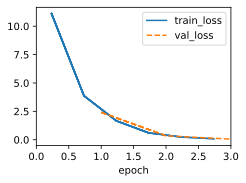

In [21]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn

# -------------------------------------------------------------------------------------------------------------------
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):  # Método Construtor: Recebe os atributos iniciais da classe ao criar um objeto
        super().__init__()               # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()      # Classe utilitária definida anteriormente
        self.board = ProgressBoard()     # Classe utilitária definida anteriormente

    def loss(self, y_hat, y):            # Função perda. Ainda não implementada.
        raise NotImplementedError

    def forward(self, X):                # Backpropagation?
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):   # plot
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):       # treinamento
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):     # validação
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):       # otimizadores
        raise NotImplementedError

# -------------------------------------------------------------------------------------------------------------------

class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self, X): #O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b   # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
		
# -------------------------------------------------------------------------------------------------------------------

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):                    # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad   # param = param - self.lr * param.grad

    def zero_grad(self):               # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
				
				
# -------------------------------------------------------------------------------------------------------------------
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):                   # Método chave. model é uma instância de Module, e data, uma instância de DataModule
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):  # @d2l.add_to_class(d2l.Trainer)  #@save
        return batch


    def fit_epoch(self):  # @d2l.add_to_class(d2l.Trainer)  #@save
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

			
			
# -------------------------------------------------------------------------------------------------------------------
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):  # usado para preparar os dados.
        self.save_hyperparameters()

    def get_dataloader(self, train):                    # Carregador de dados. Produz um lote de dados cada vez que é usado.
        raise NotImplementedError

    def train_dataloader(self):                         # retorna o carregador de dados para o conjunto de dados de treinamento.
        return self.get_dataloader(train=True)

    def val_dataloader(self):                           # opcional: retorna o carregador do conjunto de dados de validação.
        return self.get_dataloader(train=False)
		

# -------------------------------------------------------------------------------------------------------------------
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):            # batch=lotes de tamanho 32
        super().__init__()                  # A função super() encaminha os parâmetros da classe filha para a classe mãe.
        self.save_hyperparameters()
        n = num_train + num_val             # n = n_treinamento + n_validação = 1000 + 1000 = 2000
        self.X = torch.randn(n, len(w))     # matriz X (2000x2) com elementos aleatórios
        noise = torch.randn(n, 1) * noise   # vetor noise (2000x1) com elementos aleatórios
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise


    # Captura minilotes
    # def get_dataloader(self, train):
    #     if train:
    #         indices = list(range(0, self.num_train))
    #         # The examples are read in random order
    #         random.shuffle(indices)
    #     else:
    #         indices = list(range(self.num_train, self.num_train+self.num_val))
    #     for i in range(0, len(indices), self.batch_size):
    #         batch_indices = torch.tensor(indices[i: i+self.batch_size])
    #         yield self.X[batch_indices], self.y[batch_indices]                  # bathc = lote
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
		
		
# -------------------------------------------------------------------------------------------------------------------
model = LinearRegressionScratch(2, lr=0.03)
# data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
# trainer = d2l.Trainer(max_epochs=3)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')


	
	
# -------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

# Código Enxuto:

error in estimating w: tensor([ 0.0129, -0.0242])
Valor conhecido de w: tensor([ 2.0000, -3.4000])
Valor estimado de w: tensor([ 1.9871, -3.3758], requires_grad=True)

error in estimating b: tensor([0.0272])
Valor conhecido de b: 4.2
Valor estimado de b: tensor([4.1728], requires_grad=True)


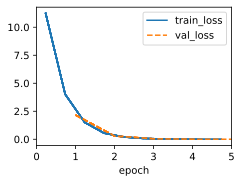

In [1]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn



# -------------------------------------------------------------------------------------------------------------------
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):                    # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad   # param = param - self.lr * param.grad

    def zero_grad(self):               # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


# -------------------------------------------------------------------------------------------------------------------
class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self, X): #O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b   # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):     #  Usamos a função de perda quadrada
        l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
# -------------------------------------------------------------------------------------------------------------------

model = LinearRegressionScratch(2, lr=0.03)  # 2 entradas
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)   # Dados sintéticos retirados de d2l

# Treinamento:
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)


with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'Valor conhecido de w: {data.w}')
    print(f'Valor estimado de w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

# Exercícios

# Ex. 2: 

Assume that you are Georg Simon Ohm trying to come up with a model for resistors that relate voltage and current. 
Can you use automatic differentiation to learn the parameters of your model?

In [ ]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn


# -------------------------------------------------------------------------------------------------------------------
class SGD(d2l.HyperParameters):  # @save
    """Minibatch stochastic gradient descent."""

    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):  # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad  # param = param - self.lr * param.grad

    def zero_grad(
            self):  # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


# -------------------------------------------------------------------------------------------------------------------
class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.I = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self,
                R):  # O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(R, self.I) + self.b

    def loss(self, V_hat, V):  # Usamos a função de perda quadrada
        l = (V_hat - V) ** 2 / 2  # Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.I, self.b], self.lr)


# -------------------------------------------------------------------------------------------------------------------

class SyntheticRegressionData(d2l.DataModule):
    """Synthetic data for linear regression.

    Defined in :numref:`sec_synthetic-regression-data`"""

    def __init__(self, I, b, noise=0.5, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.R = d2l.randn(n, len(I))
        noise = d2l.randn(n, 1) * noise
        self.V = d2l.matmul(self.R, d2l.reshape(I, (-1, 1))) + b + noise

    def get_dataloader(self, train):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.R, self.V), train, i)


# -------------------------------------------------------------------------------------------------------------------


model = LinearRegressionScratch(1, lr=0.03)  # 21 entradas
data = SyntheticRegressionData(I=torch.tensor([2.0]), b=0.0)  # Dados sintéticos retirados de d2l

# Treinamento:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
    print(f'error in estimating I: {data.I - model.I.reshape(data.I.shape)}')
    print(f'Valor conhecido de I: {data.I}')
    print(f'Valor estimado de I: {model.I.reshape(data.I.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'Valor conhecido de b: {data.b}')
    print(f'Valor estimado de b: {model.b}')

In [ ]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(data.R, data.V, 0.1);

# Ex. 3: 

Can you use Planck’s Law to determine the temperature of an object using spectral energy density? 
For reference, the spectral density of radiation emanating from a black body is B(lamb,T).

https://en.wikipedia.org/wiki/Planck%27s_law

In [ ]:
from math import log, e

c = 299792458  # m/s/; velocidade da luz
h = 6.62607015 * 10**-34 # m2 kg / s/; constante de Planck
k = 1.380649 * 10**-23 #m2 kg s-2 K-1;  constante de Boltzmann
log(B) = log(2*h*(c**2)) - 5*log(lamb) - ((h*c)/k)*((lamb*T)**-1)

# Ex. 4: 

What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would you fix them?

In [ ]:
# Answer: Include 'retain_graph=True, create_graph=True' in autograd

import torch

x = torch.arange(5.0) # tensor x
print('x:', x)
x.requires_grad_(True)
y = 2*x**3
print('y:', y)

# First derivative:
dy1 = torch.autograd.grad(y, x, grad_outputs=torch.ones(x.shape), retain_graph=True, create_graph=True)
print('dy1:', dy1)

# Second derivative:
dy2 = torch.autograd.grad(dy1, x, grad_outputs=torch.ones(x.shape), retain_graph=True, create_graph=True)
print('dy2:', dy2)

# Third derivative:
dy3 = torch.autograd.grad(dy2, x, grad_outputs=torch.ones(x.shape), retain_graph=True, create_graph=True)
print('dy3:', dy3)

# Ex. 5: 

Why is the reshape method needed in the loss function?

In [ ]:
# Answer:  Because the tensors are in different dimensions.

print(data.w.shape)
print(data.w)
print(model.w.shape)
print(model.w)

# Ex. 6: 
Experiment using different learning rates to find out how quickly the loss function value drops. 
Can you reduce the error by increasing the number of epochs of training?

In [16]:
# %matplotlib inline
import torch
import random
from d2l import torch as d2l
from torch import nn

# -------------------------------------------------------------------------------------------------------------------
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):                    # Atualiza os parâmetros
        for param in self.params:
            param -= self.lr * param.grad   # param = param - self.lr * param.grad

    def zero_grad(self):               # Define todos os gradientes como 0, que deve ser executado antes de uma etapa de retropropagação.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


# -------------------------------------------------------------------------------------------------------------------
class LinearRegressionScratch(d2l.Module):  # @save
    """The linear regression model implemented from scratch (do zero)."""

    def __init__(self, num_inputs, lr,
                 sigma=0.01):  # distribuição normal com média 0 e desvio padrão de 0,01. Bias=b=0; lr=taxa de aprendizado
        super().__init__()  # A função super() encaminha os parâmetros da classe filha (LinearRegressionScratch)
        # para a classe mãe (d2l.Module).
        # class Filha(Mae):     # Classe filha herda os atributos e métodos da classe mãe.
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1),
                              requires_grad=True)  # Vetor de pesos w é uma distribuição normal com média 0 e desvio padrão de 0,01.
        self.b = torch.zeros(1, requires_grad=True)  # bias=b=0.

    def forward(self, X): #O método resultante forward é registrado na classe anterior (LinearRegressionScratch) via decorator @add_to_class.
        return torch.matmul(X, self.w) + self.b   # Produto entre X que é a matriz de dados e w que é o vetor de pesos

    def loss(self, y_hat, y):     #  Usamos a função de perda quadrada
        l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
# -------------------------------------------------------------------------------------------------------------------


 
lr: 0.03
epochs: 10

error in estimating w: tensor([0.0006, 0.0001])
known-w: tensor([ 2.0000, -3.4000])
estimated-w: tensor([ 1.9994, -3.4001], requires_grad=True)

error in estimating b: tensor([0.0004])
known-b: 4.2
estimated-b:  tensor([4.1996], requires_grad=True)
lr: 0.03


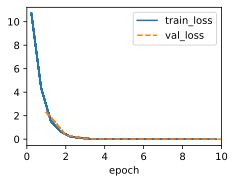

In [17]:
model = LinearRegressionScratch(2, lr=0.03)  # 2 entradas
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)   # Dados sintéticos retirados de d2l

# Treinamento:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


with torch.no_grad():
    print(f'\n \nlr: {model.lr}')
    print(f'epochs: {trainer.max_epochs}\n')
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'known-w: {data.w}')
    print(f'estimated-w: {model.w.reshape(data.w.shape)}\n')
    print(f'error in estimating b: {data.b - model.b}')
    print(f'known-b: {data.b}')
    print(f'estimated-b:  {model.b}')
    print(f'lr: {model.lr}')

lr:

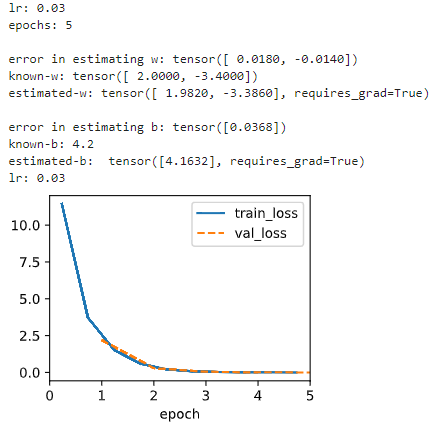

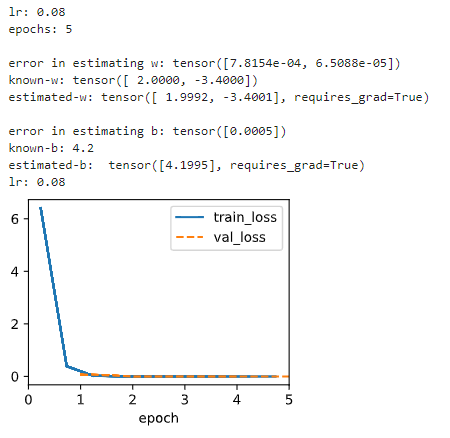

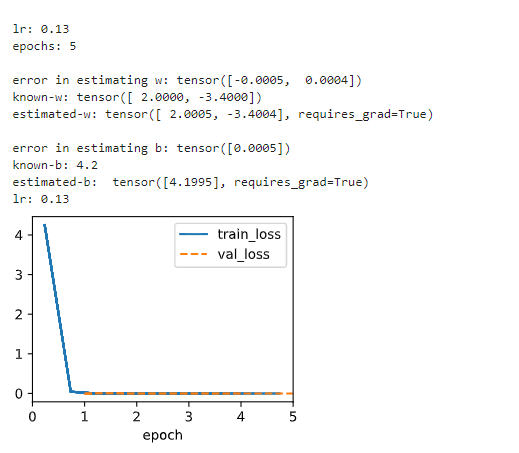

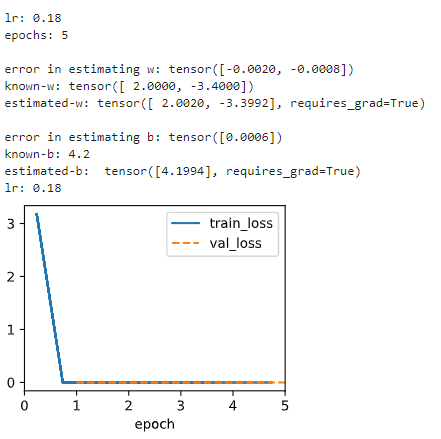

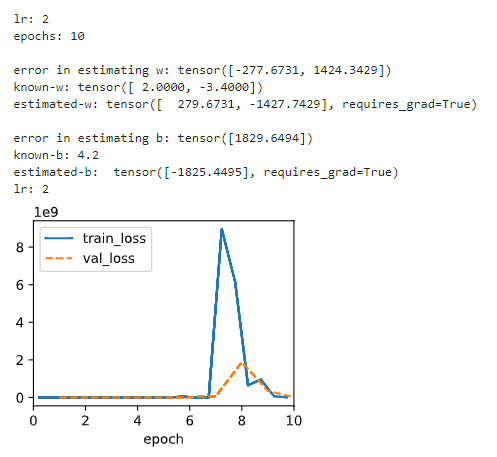

Epochs:

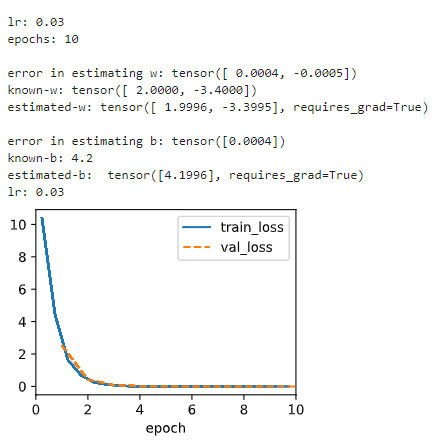

__Answer:__

The higher the lr, the faster the convergence.
If the lr is too large, overflow occurs.

The more epochs, the smaller the error.

# Ex 7. 
If the number of examples cannot be divided by the batch size, what happens to data_iter at the end of an epoch?

__Answered by pandalabme:__

We add codes below in function fit_epoch

if len(batch[0]) != 32:
    print(len(batch[0]))

We can also set parameter drop_last=True of DataLoader, if we just want to ignore the batch whose size is smaller than others.

# Ex. 8: 

Try implementing a different loss function, such as the absolute value loss (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum().

In [18]:
# A.
    def loss(self, y_hat, y):     #  Usamos a função de perda quadrada
        # l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
        return l.mean()
        

IndentationError: unexpected indent (3554486077.py, line 2)

__Squared loss:__

error in estimating w: tensor([ 0.0004, -0.0004])

Valor conhecido de w: tensor([ 2.0000, -3.4000])

Valor estimado de w: tensor([ 1.9996, -3.3996], requires_grad=True)

error in estimating b: tensor([0.0001])

Valor conhecido de b: 4.2

Valor estimado de b: tensor([4.1999], requires_grad=True)





__Absolute loss:__


error in estimating w: tensor([ 0.1575, -0.1578])

Valor conhecido de w: tensor([ 2.0000, -3.4000])

Valor estimado de w: tensor([ 1.8425, -3.2422], requires_grad=True)

error in estimating b: tensor([0.3600])

Valor conhecido de b: 4.2

Valor estimado de b: tensor([3.8400], requires_grad=True)

1)

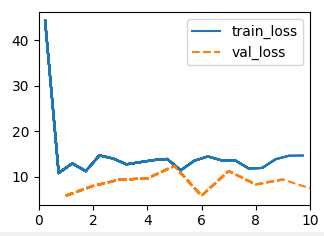

8. 2)

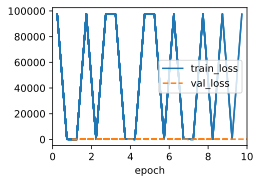

In [15]:
    def loss(self, y_hat, y):     #  Usamos a função de perda quadrada
        # l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
# -------------------------------------------------------------------------------------------------------------------

model = LinearRegressionScratch(2, lr=0.03)  # 2 entradas
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)   # Dados sintéticos retirados de d2l
data.y[4] = 10000
# Treinamento:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


8. B.

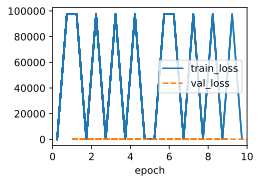

In [13]:
    def loss(self, y_hat, y):     #  Usamos a função de perda quadrada
        l = (y_hat - y) ** 2 / 2  #  Valor verdadeiro: y;  Valor previsto: y_hat.
        # l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
# -------------------------------------------------------------------------------------------------------------------

model = LinearRegressionScratch(2, lr=0.03)  # 2 entradas
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)   # Dados sintéticos retirados de d2l
data.y[4] = 10000
# Treinamento:
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


B. Squared loss: l = (y_hat - y) ** 2 / 2

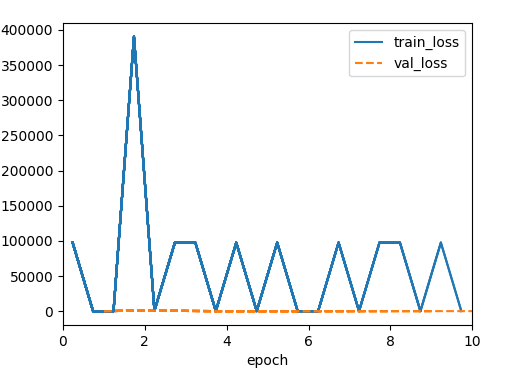

Squared loss:

error in estimating w: tensor([ 1.7120, -2.0077])

error in estimating b: tensor([-7.4510])



B. Abs loss: l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()

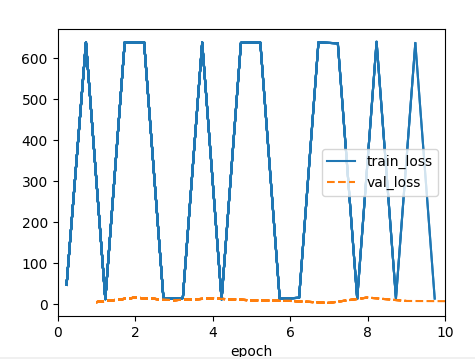

Abs loss:

error in estimating w: tensor([-0.2504,  0.0899])

error in estimating b: tensor([-0.0600])

--------------------------

Conclusion:

Without disturbing, squared loss is better.

With disturbing, absolute loss is better.

# Ex. 9. 

9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?

__Answered by pandalabme:__   
Shuffling the dataset during training is important for improving the efficiency and effectiveness of optimization algorithms, particularly stochastic gradient descent (SGD) and its variants. Shuffling serves several purposes:

Randomization: Shuffling the dataset before each epoch ensures that the model encounters the data in a random order. This randomization helps prevent the model from memorizing the order of examples, which could lead to overfitting and biased learning.

Smooth Convergence: Shuffling reduces the chances of encountering clusters of similar examples together. If the dataset has some inherent order or structure, not shuffling could cause the optimization process to converge unevenly or slowly.

Effective Exploration: Shuffling encourages the optimization algorithm to explore different parts of the loss landscape in each epoch. This can help the model escape local minima and reach a more optimal solution.